<div style="background-color:white;" >
<div style="clear: both; display: table;">
  <div style="float: left; width: 14%; padding: 5px; height:auto">
    <img src="img/TUBraunschweig_CO_200vH_300dpi.jpg" alt="TU_Braunschweig" style="width:100%">
  </div>
  <div style="float: left; width: 28%; padding: 5px; height:auto">
    <img src="img/TU_Clausthal_Logo.png" alt="TU_Clausthal" style="width:100%">
  </div>
  <div style="float: left; width: 25%; padding: 5px; height:auto">
    <img src="img/ostfalia.jpg" alt="Ostfalia" style="width:100%">
  </div>
  <div style="float: left; width: 21%; padding: 5px;">
    <img src="img/niedersachsen_rgb_whitebg.png" alt="Niedersachsen" style="width:100%">
  </div>
  <div style="float: left; width: 9%; padding: 5px;">
    <img src="img/internet_BMBF_gefoerdert_2017_en.jpg" alt="bmbf" style="width:100%">
  </div>
</div>
<div style="text-align:center">
<img src="img/ki4all.jpg" alt="KI4ALL-Logo" width="200"/>
</div>
</div>

# Synthetic Biomedical Data – Lesson 3: Advanced Data Generation
Part of the *Microcredit Artificial Data Generator* module.

➡️ [Back to Lesson 3b: Irrelevant Features - noise distributions](03b_noise_distributions.ipynb)
➡️ [Module README](../README.md)

*Before continuing, please ensure you reviewed the prerequisites and learning goals in Lesson 1.*


# Lesson 3c: Correlated Features (Biological Pathways)

### Recap
Previously, you learned that not all features are informative.
Spurious correlations between noise features and the label can arise by chance, especially as dimensionality increases.
Now we explore what happens when features are redundant because they move together.


### Why this lesson: Correlated features?
In real biomedical data, features are often not independent. Biological processes often involve groups of molecules that move together. Biological examples include:
- Genes in the same pathway may be co-expressed (e.g., Gene A and Gene B always expressed together).
- Proteins in a signaling cascade may be activated together.
- Metabolites in the same biochemical pathway are chemically linked, and their concentrations co-vary.

These dependencies create correlated features in real datasets. Strong correlations can:
- Reduce the unique information each feature provides
- Create instability in model training and feature importance
- Mislead or complicate model training and feature selection

Synthetic data allows us to add and control correlations. By simulating them in synthetic data, we can study their impact on visualization, classification, and feature selection under known ground truth.

### Key terms
- **Feature correlation**: statistical association between features (e.g., Pearson correlation).
- **Cluster / module**: a group of features that co-vary.
- **Co-variation**: features that change together across samples.
- **Equicorrelation**: all features in a cluster have nearly the same pairwise correlation.
- **AR(1) / Toeplitz**: correlation decays with distance in feature index.
- **Redundancy**: multiple features carry nearly the same information.
- **Anchor** (driver): the feature that primarily carries the class signal in a cluster.
- **Proxies**: followers that correlate with the anchor and partially mirror its information.
- **Multicollinearity**: strong feature correlations that make individual coefficients unstable (especially in linear models).
- **Attribution ambiguity (non-identifiability of individual effects)**: when several correlated features predict equally well, importance can be spread or exchanged among them.

### What you'll learn
After completing this notebook, you will be able to:
- Generate pathway-like clusters of features with a tunable correlation (e.g., equicorrelated or AR(1)/Toeplitz structure).
- Compose a dataset by mixing correlated blocks with independent features to reach a target dimensionality p.
- Visualize and interpret the empirical correlation matrix.
- Explain practical implications (redundancy, multicollinearity, non-identifiability of individual effects, proxy features) and recommend mitigation strategies (grouped selection, stability checks).

# Step 1: Code – Imports, Installation/Upgrade

In [1]:
# If needed, install or upgrade the package biomedical-data-generator(uncomment in managed environments) via:
# %pip install -U biomedical-data-generator

In [2]:
# Standard package imports
import nb_imports as nb

# Set plotting style
from nb_setup import apply_style

apply_style()

rng = nb.np.random.default_rng(42)

# Step 2. Generate synthetic data with correlated feature clusters


## 2.1 Equicorrelated Feature Cluster

**Equicorrelated features**: A correlation structure where all pairwise correlations are similar (ρ). There are no "special pairs" – all features are equally connected to all others. While rare in nature, understanding this extreme case helps us recognize feature redundancy problems.

For a cluster of k features X₁, X₂, ..., Xₖ, the equicorrelated structure means:

**Correlation Matrix**
```
     X₁   X₂   X₃   ...
X₁ [ 1    ρ    ρ   ... ]
X₂ [ ρ    1    ρ   ... ]
X₃ [ ρ    ρ    1   ... ]
...
```
All pairwise correlations are identical:

- Cor(Xᵢ, Xⱼ) = ρ for all i ≠ j
- Cor(Xᵢ, Xᵢ) = 1 (self-correlation is always 1)

### 🧬 Where Do We Find Equicorrelated Structures?
Imagine a group of biomarkers that all "move together":
- If one goes up, all others tend to go up too
- If one goes down, all others follow
- Every pair has about the same correlation ρ (rho)

#### Example 1: Transcription Factor Target Genes
Genes regulated by the same transcription factor often correlate
highly because:
- They respond to the same upstream signal via shared regulatory elements
- Coordinated expression serves a common biological goal

**Clinical implication:** Highly correlated features often have
similar predictive value—selecting "the best" single feature
becomes somewhat arbitrary without biological context.

#### Example 2: Imaging-Derived Features
Radiomics features from the same tissue region:
- Texture features (homogeneity, entropy, contrast) derived from
  overlapping pixel sets
- Mathematically related through shared image statistics
- High redundancy not obvious from feature names

**Research challenge:** Different texture features may be selected
across folds despite capturing similar information—complicating
biological interpretation.

### Generate and Visualize

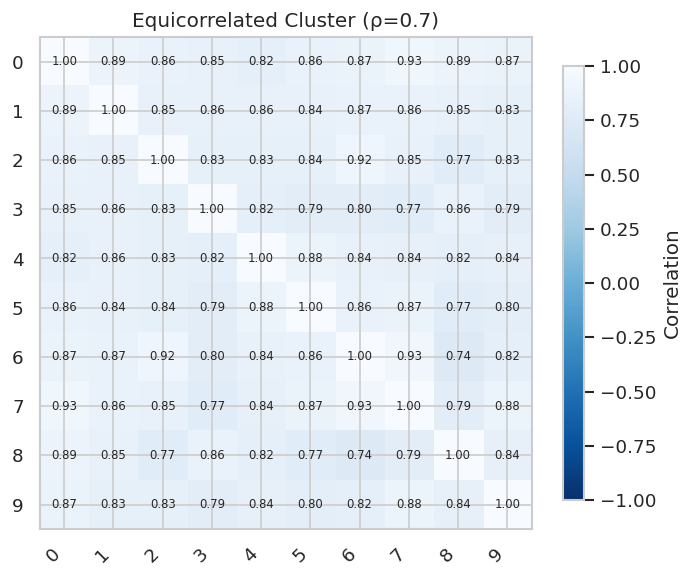

In [3]:
# Generate equicorrelated cluster
equicorrelated_cluster = nb.sample_correlated_data(
    n_samples=30,
    n_features=10,
    rng=rng,
    structure="equicorrelated",
    correlation=0.9,
)
correlation_matrix, labels = nb.compute_correlation_matrix(nb.pd.DataFrame(equicorrelated_cluster))

# plot the heatmap
fig, ax = nb.plot_correlation_matrix(
    # Compute correlation matrix from cluster_data
    correlation_matrix=correlation_matrix,
    labels=labels,
    title="Equicorrelated Cluster (ρ=0.7)",
    annot=True,
)

### Equicorrelated cluster — how to read this heatmap

**What you see**

All off-diagonal entries are close to the same value. The diagonal is exactly 1. Small deviations from perfect uniformity arise due to limited sample size.

**Interpretation**

This block represents a one-factor (shared-signal) structure: every feature carries the same latent component, so any pair of features is similarly correlated. Unique information per feature is limited and largely redundant.

An equicorrelated block encodes a single shared biological signal (e.g., a co-regulated module). It’s ideal for studying how structured redundancy affects learnability, interpretability, and stability in high-dimensional settings.

### Why This Matters for Machine Learning
- High ρ → features are nearly redundant (multicollinearity)
- Feature selection becomes non-identifiable: any cluster member
  can serve as proxy for the others
- Including 10 highly correlated texture features
doesn't give you "10× more information" – it inflates feature
importance scores and destabilizes selection.

## 2.2 Toeplitz/AR(1) Feature Cluster: When Distance Matters

**Toeplitz/AR(1) features**: A correlation structure where correlation decays exponentially with distance (ρ^|i-j|). Features have a natural ordering (sequence, time, position), and only nearby features share strong redundancy. Common in real biological data—gene expression cascades, chromosomal neighborhoods, metabolic pathways—making it essential for realistic synthetic benchmarks.

### Terminology: Toeplitz vs. AR(1)

We use two equivalent terms depending on the domain context. Both terms describe the same correlation matrix.

#### **Toeplitz Structure** (Linear Algebra)
Toeplitz describes the mathematical form of the correlation matrix where diagonals are constant and features have a **"near/far"** relationship without directionality.

#### **AR(1) Process** (Time Series)
AR(1) describes a data-generating mechanism where each value depends on its predecessor:

$$X_t = \rho \cdot X_{t-1} + \varepsilon_t$$

This autoregressive process naturally produces Toeplitz correlation.
Features have a **"before/after"** relationship with directionality. Examples are temporal dynamics (time series, cascades) or sequential processes (metabolic pathways).

### The Correlation Pattern

When features have positional or temporal ordering, correlation typically decays exponentially with distance:

$$\text{Cor}(X_i, X_j) = \rho^{|i-j|}$$

This creates a localized "neighborhood" structure:
- **Immediate neighbors** (distance 1): correlation = ρ
- **Next-door neighbors** (distance 2): correlation = ρ²
- **Distant features** (distance k): correlation = ρ^k

For a cluster of k features X₁, X₂, ..., Xₖ, the Toeplitz/AR(1) structure means:

**Correlation Matrix R**
```
     X₁    X₂    X₃    X₄   ...
X₁ [ 1     ρ     ρ²    ρ³  ... ]
X₂ [ ρ     1     ρ     ρ²  ... ]
X₃ [ ρ²    ρ     1     ρ   ... ]
X₄ [ ρ³    ρ²    ρ     1   ... ]
...
```
**Distance-dependent correlation:**
- Cor(Xᵢ, Xᵢ₊₁) = ρ (neighbors)
- Cor(Xᵢ, Xᵢ₊₂) = ρ² (distance 2)
- Cor(Xᵢ, Xᵢ₊ₖ) = ρ^k (distance k)
-
**Example:** With ρ = 0.7:
- Cor(X₁, X₂) = 0.70 (strong)
- Cor(X₁, X₃) = 0.49 (moderate)
- Cor(X₁, X₅) = 0.24 (weak)
- Cor(X₁, X₁₀) = 0.03 (negligible)

### 🧬 Where Do We Find the Toeplitz/AR(1) Pattern?

Biomarker groups with inherent positional or temporal structure:

- **Gene expression cascades**: Upstream genes regulate downstream genes
- **Chromosomal position**: Nearby genes share regulatory elements
- **Metabolic pathways**: Sequential enzymatic steps
- **Temporal measurements**: Hormone levels throughout a circadian cycle
- **Spatial transcriptomics**: Gene expression from adjacent tissue regions

In each case, correlation decays with distance.

### Generate and Visualize

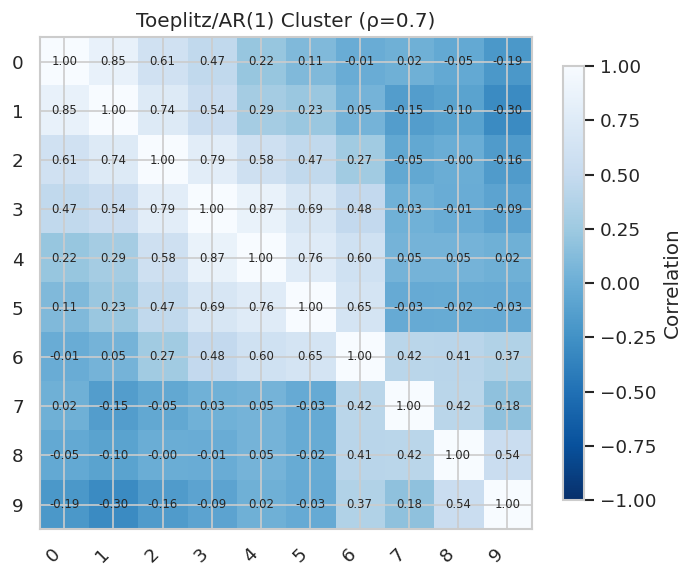

In [4]:
# Generate Toeplitz/AR(1) cluster (mimics sequential regulatory cascade)
toeplitz_cluster = nb.sample_correlated_data(
    n_samples=30,
    n_features=10,
    rng=rng,
    structure="toeplitz",  # Changed from "equicorrelated"
    correlation=0.7,  # Lag-1 correlation; correlation decays as ρ^k with distance
)
correlation_matrix, labels = nb.compute_correlation_matrix(nb.pd.DataFrame(toeplitz_cluster))

# plot the heatmap
fig, ax = nb.plot_correlation_matrix(
    correlation_matrix=correlation_matrix,
    labels=labels,
    title="Toeplitz/AR(1) Cluster (ρ=0.7)",
    annot=True,
)

### Toeplitz / AR(1) cluster — how to read this heatmap

**What you see**

The diagonal is 1 by definition. Correlations are strongest near this main diagonal and decay with distance from it. This shows a banded pattern where nearby features are highly correlated, and distant features have low correlation. Small variations from the ideal pattern occur due to limited sample size. With unlimited samples, the empirical correlations would match the theoretical Toeplitz structure exactly.

**Interpretation**

Nearby features share more signal than distant ones. This creates a "neighborhood" structure where redundancy is localized. Features share information primarily with their immediate neighbors, not the entire cluster. This reflects biological processes where local dependencies dominate, such as gene expression cascades or chromosomal neighborhoods.

### Why This Matters for Machine Learning

1. **Localized Feature selection instability**: Correlated neighbors are interchangeable
2. **Interpretation challenges**: Which gene in a chromosomal region is "causal" vs. just a correlated neighbor?
3. **Overfitting via redundant neighborhoods**: High-dimensional data with multiple local clusters creates many correlated pathways
4. **Realistic benchmarks**: Real biomarker panels often have this structure

**Key difference from equicorrelated features:**
- Redundancy is local, not global → distant features (e.g., Feature 1 and Feature 100) add independent information
- Multicollinearity still present, but localized to neighborhoods → not every feature competes with every other
- Selection stability improves between neighborhoods → choosing one feature from each cluster is more reproducible

## Explore Correlation Strength
**Task:** Modify the code above to generate clusters with different ρ values (0.3, 0.7, 0.95).
- How does the heatmap change?
- At what ρ do features become practically redundant?
- What implications does this have for feature selection?

**Expected output:** Three heatmaps showing different correlation strengths.

# Step 3. Generate a Dataset with Two Correlated Clusters and High-Dimensional Noise

From isolated clusters to full data set: We now generate a complete p≫n dataset (1225 features, 120 samples) with the `biomedical-data-generator` where two small correlated pathways carry class information while being drowned in high-dimensional noise. This reflects the challenge biomedical researchers face—finding signal among overwhelming irrelevant variation.

In each of the two pathways, only one feature (the "anchor") truly differs between classes. The other features are correlated "proxies" that follow their anchor without their own class effect. This reveals how correlation makes many features appear important even when only a few are causal.

#### Generator Settings
* **Samples and classes**

  >2 balanced classes with 120 samples for stable comparisons.

* **Correlated clusters** (`corr_clusters`)
  >- **Pathway A** (10 features): Equicorrelated with `correlation=0.7` — all pairs share identical correlation (global redundancy).
  >- **Pathway B** (15 features): Toeplitz with `correlation=0.6` — correlation decays with distance, which mimics local dependencies.


* **Anchors vs. proxies**

  >`anchor_role="informative"` makes the first feature in each pathway the class-informative anchor. All other features in that pathway are correlated proxies without their own class shift.

* **Effect sizes**

  >`anchor_effect_size="medium"` gives moderate separation for the two anchors. `class_sep=1.2` scales the overall task difficulty—high enough to require modeling, low enough to avoid trivial perfect separation.

* **Informative feature count**

  >`n_informative=2` — exactly the two pathway anchors. No additional standalone informative features.

* **High-dimensional noise**

  >`n_noise=1200` adds independent features unrelated to class, creating realistic p≫n conditions (1225 features vs. 120 samples).

* **Pathway independence**

  >`corr_between=0.0` keeps the two pathways uncorrelated, creating visually distinct blocks in correlation heatmaps.

* **Reproducibility**

  >`random_state=42`. Feature names use `feature_naming="prefixed"` → expect `i1`, `i2` (anchors), `corr1_1`, `corr1_2`, ..., `corr2_1`, ..., `n1`, `n2`, ... (noise).

In [5]:
cfg = nb.DatasetConfig(
    # 2 balanced classes with 120 samples
    class_configs=[
        nb.ClassConfig(n_samples=60, label="class 0"),
        nb.ClassConfig(n_samples=60, label="class 1"),
    ],
    # Correlated clusters (anchors are the only informative features in each cluster)
    corr_clusters=[
        nb.CorrClusterConfig(
            n_cluster_features=6,
            structure="equicorrelated",
            correlation=0.7,  # rho=0.7 is typical for co-regulated genes under same transcription factor
            anchor_role="informative",  # first column is the informative "anchor"
            anchor_effect_size="large",  # shift strength for the anchor
            anchor_class=0,  # one-vs-rest effect (defaults to 0 if omitted)
            label="Pathway A (equicorr)",
        ),
        nb.CorrClusterConfig(
            n_cluster_features=8,
            structure="toeplitz",
            correlation=0.6,
            anchor_role="informative",
            anchor_effect_size="medium",
            anchor_class=1,  # anchor targets class 1 here
            label="Pathway B (toeplitz)",
        ),
    ],
    # Important: n_informative must include the number of informative anchors
    n_informative=2,  # exactly 2 anchors above → no extra free informative features
    n_noise=1200,  # a bit of extra noise to make p>n
    class_sep=[1.2],  # modest separation so redundancy/correlation still matters
    corr_between=0.0,  # keep clusters independent for clarity
    feature_naming="prefixed",  # i1, corr1_2, ..., n1, n2, ...
    random_state=42,
)

x, y, meta = nb.generate_dataset(cfg, return_dataframe=True)

## Plot the correlation heatmap

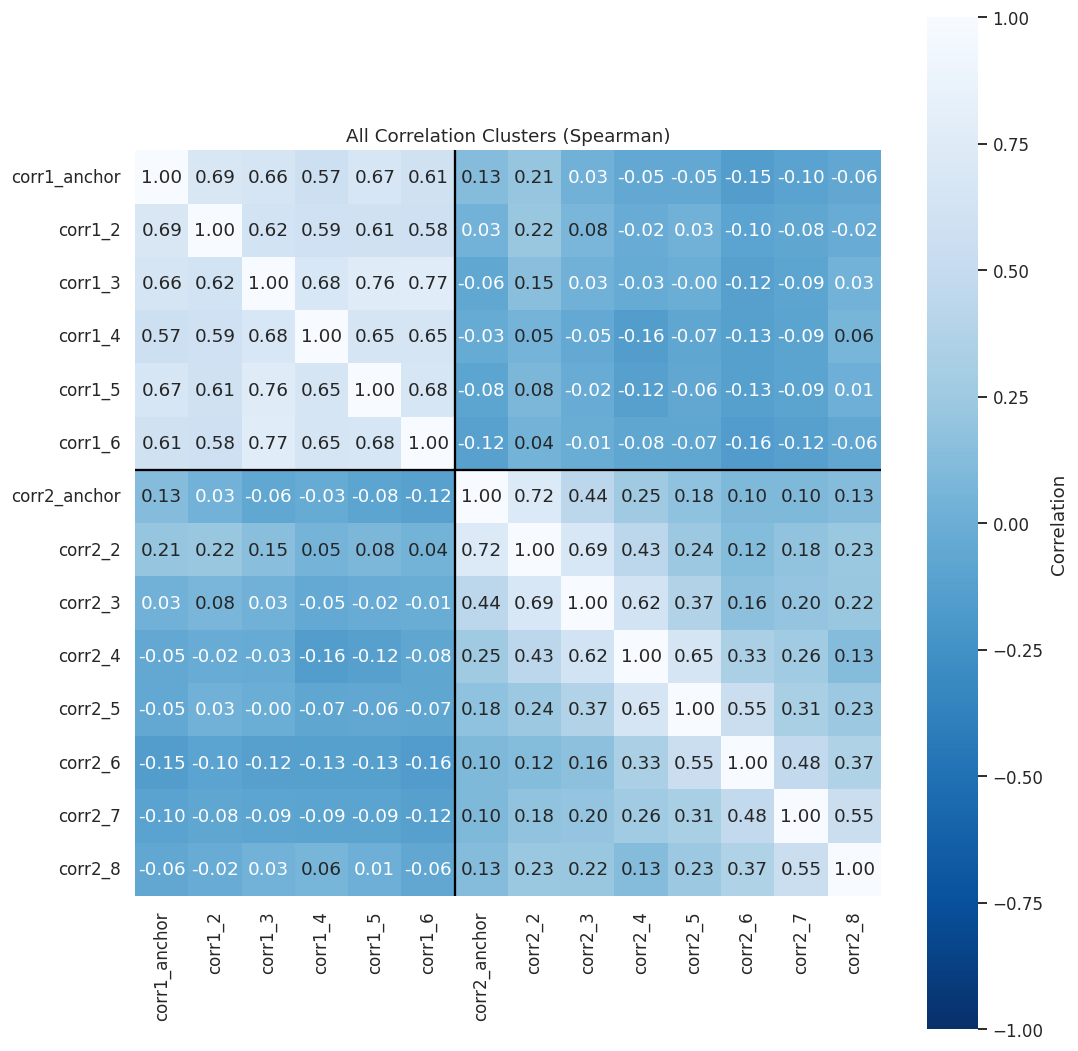

In [6]:
fig, ax = nb.plot_all_correlation_clusters(df=x, correlation_method="spearman")

### Interpreting the Correlation Structure

The heatmap visualizes the **empirical pairwise correlations** between all features across two simulated clusters:
- **Cluster 1 (left block)** follows an *equicorrelated* structure — every pair of features shares approximately the same correlation. This produces a uniform bright block, reflecting a single shared latent factor that drives all features equally.
- **Cluster 2 (right block)** follows a *Toeplitz (AR-1)* structure — correlations decay gradually with feature distance from the anchor. This creates a banded pattern where nearby features are strongly correlated, and distant ones less so.

**Interpretation**
- Within each cluster, features move together to varying degrees, mimicking biological pathways or co-regulated gene modules.
- The near-zero correlations between clusters confirm that they are **independent by design**.
- Diagonal values are 1 by definition (self-correlation).
- Small deviations from the idealized pattern arise from **finite-sample variability**.

Controlled correlation structures allow us to systematically study how **redundancy**, **multicollinearity**, and **proxy features** influence model performance and feature selection stability in high-dimensional biomedical data.

## Try It Yourself
Create a dataset where:
- Cluster 1 has 20 features with ρ=0.9 (equicorrelated)
- Cluster 2 has 15 features with ρ=0.5 (Toeplitz)
- Add 500 noise features
- Visualize the correlation structure

Can you identify both clusters in the heatmap?

# Typical pitfalls you'll observe with correlated features
Correlated features introduce several challenges in machine learning pipelines, especially in biomedical contexts where pathways and co-regulated modules are common. Here are some typical pitfalls:
### Feature selection issues:

* Redundant picks: Selectors choose many proxies from one anchor cluster → low diversity, inflated feature counts
* Unstable rankings: Correlated features swap positions across resamples/CV folds → unreliable interpretation
* Split votes: Selection algorithms "distribute" importance across cluster members instead of identifying the anchor
* Masked coefficients: In linear models, coefficients shrink or flip sign under strong collinearity → misleading effect sizes

### Model evaluation traps:
* Leakage via feature selection: Selecting features on full data before CV → overly optimistic performance estimates
* Group structure ignored: Random CV splits batches/sites between train and test → artificially high scores when batch effects exist
* Metric blindness: Accuracy looks great even when model relies entirely on one correlated cluster (or noise with lucky correlation)
* Overfitting to correlation structure: Model memorizes which features "travel together" rather than learning true class signal

### Cross-validation failures:
**Correlation-specific issues:**
* Instability across folds: Different CV folds select different correlated features
  → model composition changes unpredictably

**General p≫n issues (worsened by correlation):**
* Feature selection leakage: Standard k-fold CV combined with feature selection
  on full data → information leaks from test into training
* Nested CV is necessary but often skipped → hyperparameter tuning leaks information
* Small sample size (n=50–100) + many features (p=500) → high variance in CV
  estimates, single splits misleading


## Why generate correlated features for benchmarking?
Correlated features stress-test the entire ML pipeline in ways uncorrelated synthetic data cannot:
### 1. Expose feature selection fragility

* Methods like Lasso, mRMR, or univariate filters must decide which cluster member to pick
* Different seeds/resamples → different choices → unstable gene/biomarker lists
* Ground truth benefit: You know features 0–9 are informative; if the selector picks features 11, 23, 45 (all correlated noise), you can prove it failed

### 2. Test model robustness to multicollinearity

* Linear models: do regularization methods (Ridge, Lasso, ElasticNet) correctly handle redundancy?
* Tree-based models: are they truly "immune" to correlation, or do they still split votes across cluster members?
* Controlled comparison: Generate identical class separation with r=0.0, 0.5, 0.9 → observe degradation

### 3. Reveal metric blind spots

* A model using only one noisy cluster member can achieve AUC=0.85 if that member happens to correlate with the outcome
* Permutation baselines become critical: shuffle class labels → does performance drop? If not, model found spurious structure
* Correlation amplifies the risk of "good metrics, bad model"

### 4. Force proper cross-validation discipline

* With correlated features, naive CV (select features → split → train) always leaks information
* Nested CV is the only valid approach, but it's computationally expensive and often skipped in practice
* Synthetic benchmark: Train students/researchers to detect and avoid this mistake with data where you can quantify the bias

### 5. Simulate biological pathway structure

* Real biomedical data has correlated features (gene co-expression, metabolic pathways, protein complexes)
* Uncorrelated synthetic data is too clean → models perform unrealistically well, then fail on real data
* Realism test: If a method can't handle r=0.7–0.9 in synthetic data, it won't handle real biological pathways

### 6. Enable stability analysis

* Run 100 bootstrap resamples → measure Jaccard stability, Kuncheva index
* Expected outcome: Correlated features → low stability (≈0.3–0.5), uncorrelated → high stability (≈0.8)
* Provides quantitative benchmark: "This feature selection method is unstable under correlation"


# Quick takeaway
### Correlated features are:

* Biologically realistic (genes/proteins don't act independently)
* Statistically challenging (violate standard assumptions)
* Pedagogically valuable (make invisible pitfalls visible through controlled experiments)

Without correlation in synthetic data, learners miss the most common real-world failure modes. Generating Toeplitz/AR(1) clusters is relevant to explore how correlation strength (ρ) and cluster size affect model behavior and feature selection stability.

## Next Steps

In **Lesson 3d: Non-Causal Variation**, you will:
- Add **batch effects** and **pseudo-classes** (site, instrument, eye color) to simulate non-causal subgroups.
- Create **confounding** where models learn subgroup membership instead of biology.
- Expose the failure of **Random CV** and learn when **Group CV** is essential.

➡️ Continue with: **[`03d_non_causal_variation.ipynb`](03d_non_causal_variation.ipynb)**